# lun2nov2015

we don't have sufficent power to fit correctly.
The highest power is 4mW

(just to know, the spot radius was 6 um)

In [1]:
import sys
# include the toolkit path in the modules paths
sys.path.append('../../scripts')

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.html.widgets import interact

# maths
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit, minimize, leastsq

# the opsin-model toolkit
import marco_tools as mt

import quantities as pq

# plotting constants
FIG_BIG = (15,10)
FIG_H = (15,7)
FIG_SMALL = (7,7)

# help setting the text in a plot
def default_plot_setup(title='Title', xlabel='x',ylabel='y'):
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<img src="lun2nov2015.jpeg">

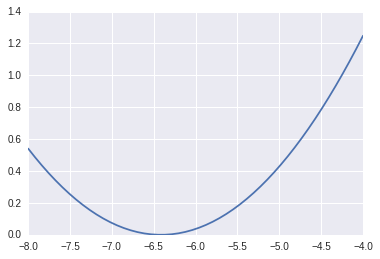

In [2]:
def power(x):
    p0 = 0#-0.52686
    A = 186.27324
    xc = -6.41306
    w = 92.49629
    return p0 + A*(np.sin(np.pi*(x-xc)/w))**2

x=np.linspace(-8,-4)
plt.plot(x,power(x))

# mW



In [3]:
foldername = ("/home/marco/Desktop/ospin_model/opsin_model/experimental/CoChR Valeria - power too low/DAtaCochR_Valeria/txt/lun2nov2015c1/temp/")
import os,re
filenames = os.listdir(foldername)
# l=[]
# for f in filenames:
#     print re.search(r'.+_(\d+)_(.+)-(\d)(p(\d+))?(\.txt)',f).groups()
filenames = sorted(map(lambda x : x.split('.')[0], filenames))
filenames = map(lambda x : x + '.txt', filenames )

print filenames

['048.txt', '049.txt', '050.txt', '051.txt', '052.txt', '053.txt', '054.txt', '055.txt', '056.txt', '057.txt', '058.txt', '059.txt', '060.txt']


In [5]:
exps = mt.ExperimentCollection()

powervalues = map(power,np.array([-5,-6,-5.5,-4.5,-4,-4.25,-3.5,-3,-2,-5.75,-5.75,-5.75,-5.25]))
temp_powervalues = []

for i,fn in enumerate(filenames) : 
    if fn.split('.')[0] in ['059','057','058', '049','060','050'] : continue
    ydata = np.loadtxt(foldername+fn)
    xdata = np.linspace(0,1,len(ydata))
    e = mt.OpsinExperiment(ydata, xdata=xdata)
    e._x_units = 's'
    e._y_units = 'pA'
    e.label = fn.split('.')[0]

    e.y.substract_constant(np.mean(e.y[-500:]))
    e.select_by_time(0,0.5)
#     e.resample(10)
#     e.smoothing(n=10)
#     e.y.substract_mean(start_x=0.5)

    e.y.invert() 
    e.change_x_reference(0.1+0.001)
    e.pulse_start = 0
    e.update_raw_data_from_current()
    
    exps.append(e)
    temp_powervalues.append(powervalues[i])
    
    
# exps = exps[0:-2]
# exps.pop(3)

powervalues = temp_powervalues

../../scripts/marco_tools/Experiment.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if xdata == None:


(0, 2000)

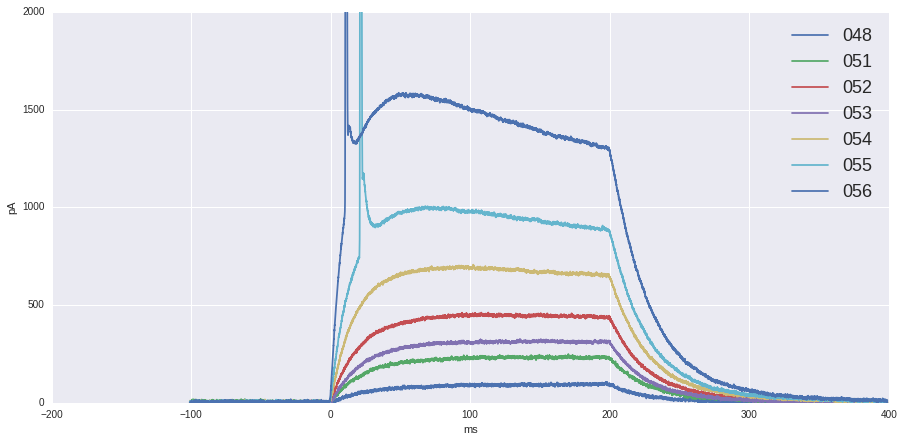

In [6]:
# pulse_durations =np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1, 0.05])
# set pulse_end
plt.figure(figsize=(5,5))

pulse_durations =np.array([200]*len(exps))
for i,e in enumerate(exps):
    e.pulse_end = 200


# for i,e in enumerate(exps):
# #     e.label = e.label + ' p' + str(np.round(powervalues[i],2)) + " mW"
#     e.plot(label=e.label)
# #
# # plt.legend(loc=1, prop={'size':18})
# plt.xlabel("time [s]")
# plt.ylabel("curent [pA]")
# pulse_end = [0.7]

plt.figure(figsize=FIG_H)

for i,e in enumerate(exps):
#     e.label = e.label + ' p' + str(np.round(powervalues[i],2)) + " mW"
    e.convert_x('ms')
    e.plot(label=e.label)
    
plt.legend(loc=1, prop={'size':18})
plt.ylim([0,2000])

(-100, 2723.6948827990041)

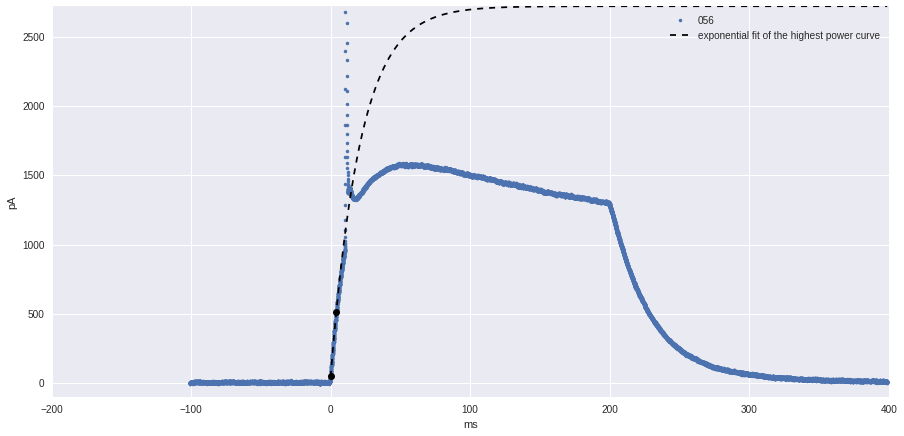

In [12]:
e = exps[-1]

plt.figure(figsize=FIG_H)
e.plot('.')
### OpsinFit is an object that helps fitting these parameters.
fit = mt.OpsinFit(e)
fit.fit_parameter("max_current", start_fit_time=-.1, end_fit_time=4)
fit_result = fit.model("max_current")
bnd = fit.fit_bnds("max_current")
norm_param = fit.max_current

# plt.plot(np.linspace(0,500,100),[norm_param]*100,'--',label="max current in a two level system = {}".format(int(round(norm_param))));
plt.plot(fit_result[0],fit_result[1],'k--',label="exponential fit of the highest power curve")
plt.plot(bnd[0],bnd[1],'ko')

plt.legend();
plt.ylim([-100,norm_param])
# plt.xlim([-0.0,0.02])


we think that this courve is no good for fitting the max current since the power is too low

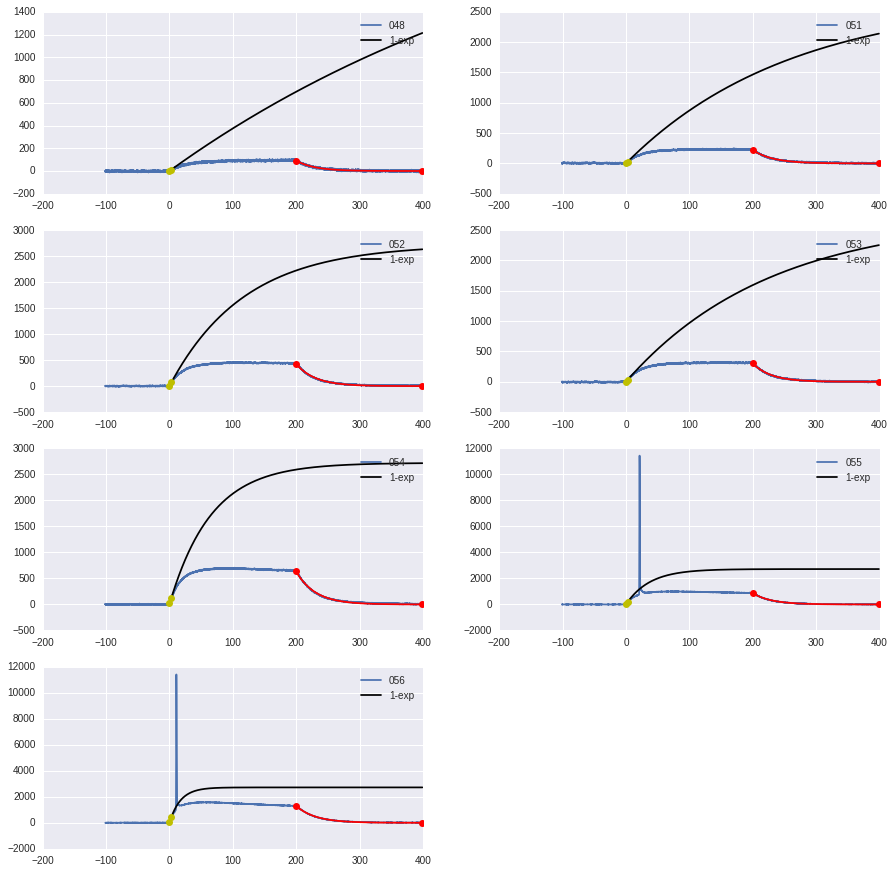

media tau_off 30.1559688624
media tau_on 200.12626676


In [13]:

plt.figure(figsize=(15,15))


plots = len(exps)
cols = 2
rows = plots/cols + plots%cols

pulse_end_times = []
tau_ons = []
tau_offs = []
sstate = []

for i,e in enumerate(exps):
  
    # fit tau_on and tau_off
    fit.e = e
#     fit.fit_parameter("max_current", start_fit_time=0, end_fit_time=0.0014)
    fit.fit_parameter("tau_on", start_fit_time=0,end_fit_time=3.2)
    fit.fit_parameter("tau_off", start_fit_time=pulse_durations[i] , end_fit_time=pulse_durations[i]+300, p0=[100,100])
       
    pulse_end_times.append(e.pulse_end)

    
    tau_ons.append(fit.tau_on)
    tau_offs.append(fit.tau_off)

    # theoretical statdy state
    k_on = 1.0/fit.tau_on
    k_off = 1.0/fit.tau_off
    sst = k_on/(k_on+k_off)*norm_param
    sstate.append(sst)
    
    
    plt.subplot(rows,cols,i+1)
    # default_plot_setup(title= 'power= ' + str(round(e.light_power,3)),xlabel='',ylabel='')

    plt.plot(e.x, e.y, label=e.label )
    plt.plot(fit.model("tau_off")[0],fit.model("tau_off")[1],'r')
    plt.plot(fit.model("tau_on")[0],fit.model("tau_on")[1],'k', label="1-exp")
    plt.plot(fit.fit_bnds("tau_off")[0],fit.fit_bnds("tau_off")[1],'ro')
    plt.plot(fit.fit_bnds("tau_on")[0],fit.fit_bnds("tau_on")[1],'yo')
    #plt.plot(np.linspace(0,500,100),[sst]*100,'--g',label='2 levels steady state')

    plt.legend()

#     plt.axis([-0.05,0.3,-100,norm_param+10])
    

    
plt.show()
# store the mean value of tau off
tau_off = np.mean(tau_offs)
#tau_on = np.mean(tau_ons)
print "media tau_off", np.mean(tau_offs)
print "media tau_on", np.mean(tau_ons)

In [9]:
tau_ons

[676.24309233429437,
 258.95959408643222,
 117.90907348761947,
 227.25840867062701,
 65.561040143151288,
 37.496705466302465,
 17.455953134658674]

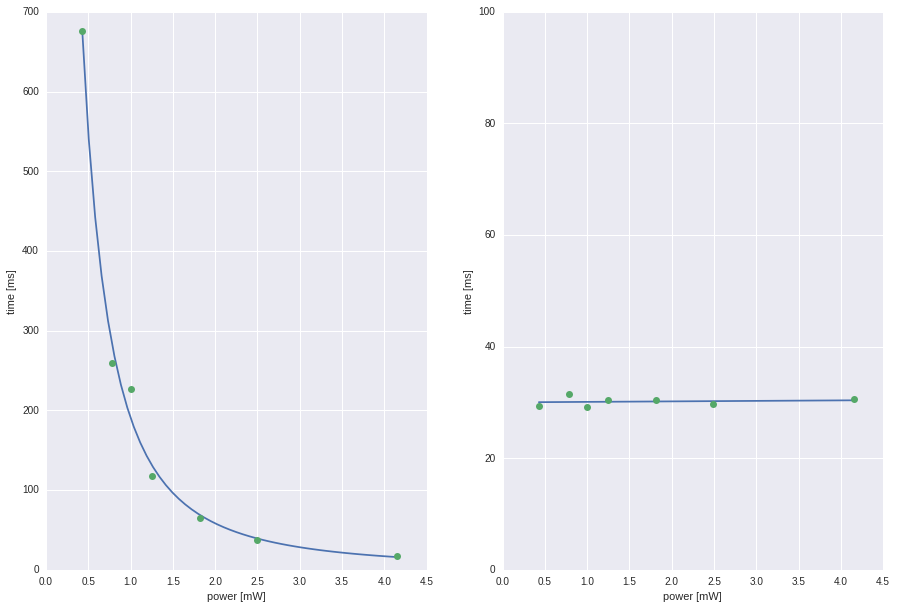

In [24]:
plt.figure(figsize=(15,10))

x=np.linspace(min(powervalues),max(powervalues))

# def func_on(x,m,q,c):
#     return m / ((x)**2)

def func_on(x,m,q,c):
    return m / ((x+q)**2) + c

def func_off(x,m,q):
    return m*x + q

popt_on, pcov_on = curve_fit(func_on,
                             powervalues,
                             np.array(tau_ons),
                             p0=[10,0,0]
                            )

plt.subplot(1,2,1)
plt.plot(x, func_on(x, *popt_on),'-')
plt.plot(powervalues, tau_ons,'o',label='tau_on')
plt.xlabel('power [mW]')
plt.ylabel('time [ms]')

popt_off, pcov_off = curve_fit(func_off,
                               powervalues,
                               np.array(tau_offs),
                               p0=[0, 50]
                              )
plt.subplot(1,2,2)
plt.plot(x, func_off(x,popt_off[0],popt_off[1]),'-')
plt.plot(powervalues, tau_offs,'o',label='tau_off')
plt.ylim([0,100])
plt.xlabel('power [mW]')
plt.ylabel('time [ms]')

In [17]:
popt_on

array([  2.79945322e+02,   2.15983299e-01,   1.26904307e+00])

In [25]:
# lightpower = 1

# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES
K_off = np.zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  np.zeros([3,3]) # transition coefficient MATRIX when light is ON

k = 1.0/tau_off

K_off[O,C] = k
K_on[O,C] = k # this transition does not depend on light


In [26]:
def func_kd(t,kod,kdc):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,C] = kdc
#     K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]

In [27]:
### THE WORKING FUNCTION
# names = ['Kod','Kdo']
# def func_kd(t,kod,kdo):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,O] = kdo
    
#     v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
#     return v[:,1]

### BENOIT's TEST
names = ['Kod','Kdc']
def func_kd(t,kod,kdc):
    K_on[O,D] = kod
    K_off[O,D] = kod
    K_on[D,C] = kdc
    K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]


# RESIDUAL REDEFINITION WITH PENALIZATION
def residuals(p,x,y):
    if any(p < 0):
        penalization = 10**3
    else:
        penalization = 0
    
    return y - func_kd(x,p[0],p[1]) + penalization

popt_kd = np.zeros((len(exps),2))
initial_condition = [norm_param,0,0]

print "WARGING : if measurement errors are not specified,\
confidence intervals do not make much sense\n"
# print "68% CONFIDENCE INTERVALS:"

for i,e in enumerate(exps) :
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    K_on[C,O] = 1.0/this_tau_on
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
    popt_kd[i], pcov_kd = leastsq(func=residuals,
                                  args=(e.x, e.y),
                                  x0=[ 0.004,  0.0060],#(0.0037040842731901466, 8.9556673674207084e-05),#[0.002,0.0001],#(1./100,10.0/100),
                                  full_output=True)[0:2]
    
    print "curve %x" % i
    for j,p in enumerate(popt_kd[i]):
        print "{} : {:.2E} +/- {:.2E}".format(names[j], p, np.sqrt(pcov_kd[j,j]))
    print ""

for i in range(popt_kd.shape[1]):
    k_temp = np.mean(popt_kd[:,i])
    print "mean {} : {:.2E},\t tau = {:.2E} ms".format(names[i], k_temp, 1.0/k_temp)

WARGING : if measurement errors are not specified,confidence intervals do not make much sense

curve 0
Kod : 8.20E-03 +/- 3.91E-06
Kdc : 3.76E-03 +/- 8.43E-07

curve 1
Kod : 4.00E-03 +/- 1.09E-06
Kdc : 6.00E-03 +/- 5.95E-07

curve 2
Kod : 3.49E-03 +/- 1.30E-07
Kdc : 6.51E-03 +/- 8.07E-07

curve 3
Kod : 5.33E-03 +/- 6.62E-07
Kdc : 5.81E-03 +/- 6.37E-07

curve 4
Kod : 4.50E-03 +/- 2.77E-07
Kdc : 4.86E-03 +/- 2.68E-07

curve 5
Kod : 4.34E-03 +/- 1.67E-07
Kdc : 5.18E-03 +/- 1.23E-07

curve 6
Kod : 3.71E-03 +/- 1.42E-07
Kdc : 6.30E-03 +/- 8.47E-08

mean Kod : 4.80E-03,	 tau = 2.09E+02 ms
mean Kdc : 5.49E-03,	 tau = 1.82E+02 ms


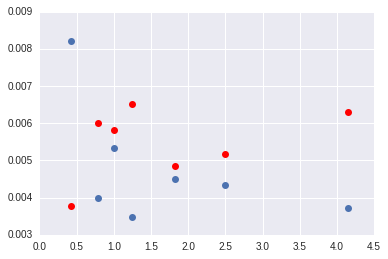

In [28]:
plt.plot(powervalues, popt_kd[:,0],'o')
plt.plot(powervalues, popt_kd[:,1],'ro')

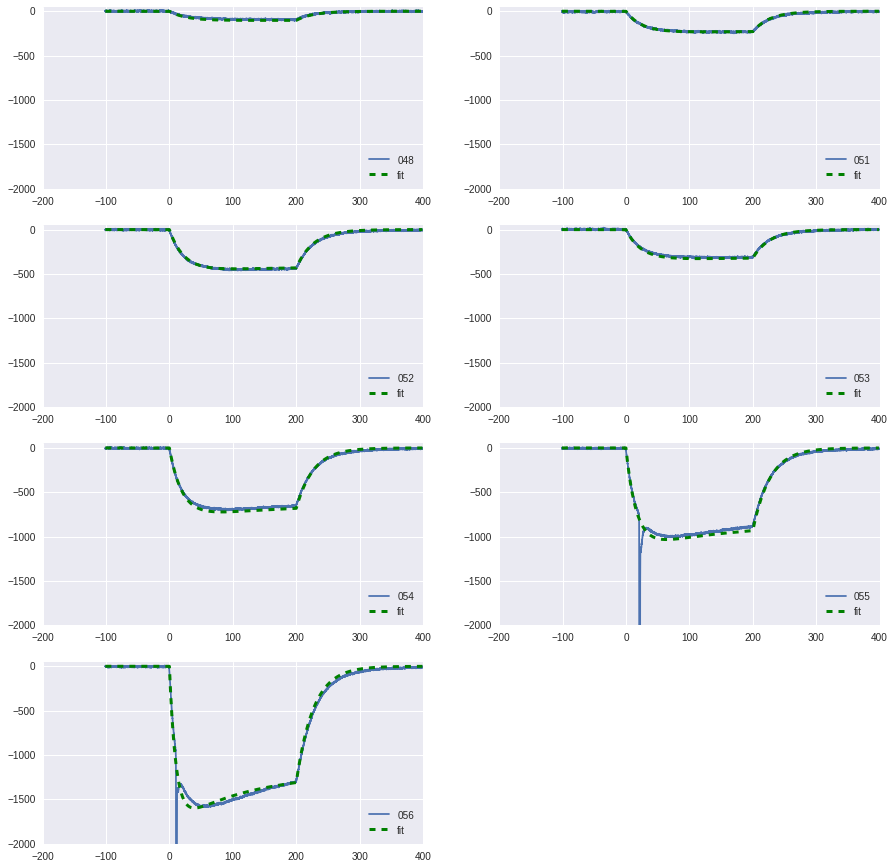

In [29]:
plt.figure(figsize=(15,15))

INVERT = -1

initial_condition = [norm_param,0,0]
def func(t):
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]


for i,e in enumerate(exps) :
    ax = plt.subplot(4,2,i+1)
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    
    K_on[C,O] = 1.0/this_tau_on
         
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
#     plt.plot(e.x,e.y)
#     plt.plot(e.x, func_kd(e.x,popt_kd[i]),'--r',lw=2)
    
    plt.plot(e.x,INVERT*e.y,label=e.label);
#     plt.plot(e.x,INVERT*func_kd(e.x,np.mean(popt_kd[:,0]), np.mean(popt_kd[:,1])),'g--',linewidth='3',label='fit');
    plt.plot(e.x,INVERT*func_kd(e.x,*[ 0.004,  0.0060]),'g--',linewidth='3',label='fit');
#     plt.plot(e.x,INVERT*func_kd(e.x,*popt_kd[i]),'r--',linewidth='3',label='fit');
#     plt.plot(e.x,INVERT*func(e.x),'r--',linewidth='3',label='fit');

    plt.legend(loc=4)
    plt.ylim([-2000,50])

In [16]:
powervalues

[0.42873536962033687,
 0.78532152258418708,
 1.2484328794030364,
 1.0035920639727058,
 1.8175352512511063,
 2.4919721909839079,
 4.1536173772656468]

In [17]:
popt_on

array([  2.79945322e+02,   2.15983299e-01,   1.26904307e+00])

In [18]:
tau_off

30.155968862376671

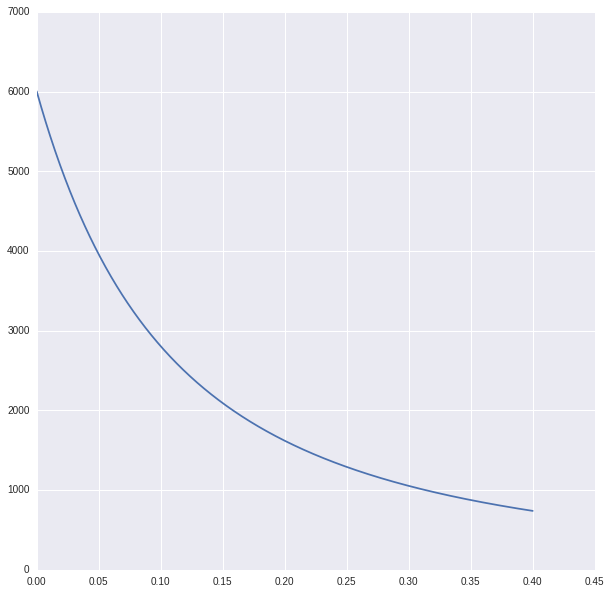

In [37]:
plt.figure(figsize=(10,10))
x = np.linspace(0,0.4,1000)
plt.plot(x,func_on(x,2.79945322e+02,   2.15983299e-01,   1.26904307e+00))

In [33]:
exps[-1].label

'056'

In [35]:
norm_param

2723.6948827990041